In [1]:
# The code was removed by Watson Studio for sharing.

# Capstone Project - The Battle of the Neighborhoods 
### Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a zumba club. Specifically, this report will be targeted to stakeholders interested in opening an **Zumba Fitness Club** in **New York**, The United-States.

Since there are lots of Fitness Club in New York we will try to detect **locations that are not already crowded with gymnasium**. We are also particularly interested in **areas with no Zumba Fitness Club in vicinity**. We would also prefer neighborhoods **with high percentage of Hispanic population**, assuming that first two conditions are met.

We want to consider also other factors in our decision making, particularly socio-economic factors. For that we would  opt for neighborhoods where **unemployment rate is acceptable**, **average income is medium to high** and where **average rent price is acceptable**.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* Number of existing Fitness Club in the neighborhood (any type of gym)
* Number of and distance to Zumba Club in the neighborhood, if any
* Percentage of Hispanic population
* Unemployment rate, average income, average rent price 


Following data sources will be needed to extract/generate the required information:
* The number of gym or fitness club and their type and location in every neighborhood will be obtained using **Foursquare API**
* The list of the neighborhoods will be extracted from **[here](http://www.infoshare.org/misc/SBANYC.pdf)** but I already convert it into an excel file.
* Then we will use the **Shapely** library of python to compute the Coordinates of the centroid of the multipolygon of each neighborhood. The geojson file for that was obtained from **[here](https://geodata.lib.berkeley.edu/catalog/sde-columbia-census_2000_032807211977000)** 
* The number of Hispanic population will be obtained from csv files downloaded from **[here](http://www.infoshare.org/mod3/main.aspx)** and the The percentage will be obtained by directly calculating it.
* The Socio-economic data will be obtained from csv file downloaded from **[here](http://app.coredata.nyc)**. It contains the Labor force participation rate, the Unemployment rate, the Median household income, and the Median rent for each neighborhood.

### Initialization and main data collection

##### 1-1 Import libraries

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import csv
import requests 

import json 
from pandas.io.json import json_normalize 

#!conda install -c conda-forge geopy --yes 
!pip install geopy
from geopy.geocoders import Nominatim

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 
!pip install folium
import folium 

print('Libraries imported.')

Libraries imported.


##### 1-2 Getting Geospatial Data of New York City

###### Import Sub-boroughs name into a DataFrame

Neighborhood has a total of 5 boroughs and 55 sub-boroughs that we will consider in this projects as the neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

In [2]:
# The code was removed by Watson Studio for sharing.

ID               Sub-borough name Borough
0  101       Mott Haven / Hunts Point   Bronx
1  102      Morrisania / East Tremont   Bronx
2  103      Highbridge / S. Concourse   Bronx
3  104   University Heights / Fordham   Bronx
4  105  Kingsbridge Heights / Mosholu   Bronx

###### Get the geographical coordinates

Let's import first our geojson data.

In [3]:
from botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='9qV9m61P-7lupUr-Xa7whmcguBYB7gHavjM2s5yqKmhL' ,
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

In [4]:
cos.download_file(Bucket='capstoneproject-donotdelete-pr-djsnullrdmehby',Key='sde-columbia-census_2000_032807211977000-geojson.json',Filename='newyork-geojson.json')

In [5]:
with open("newyork-geojson.json", 'rb' ) as f:
    newyork_data = json.load(f)["features"]

As our geojson data is not composed of "Points" but "Multipolygons", let's transform it into points by calculating the latitude and the longitude of the centroid of each multipolygon using the library **Shapely**

In [7]:
!pip install shapely
import shapely.geometry

!pip install pyproj
import pyproj

/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.

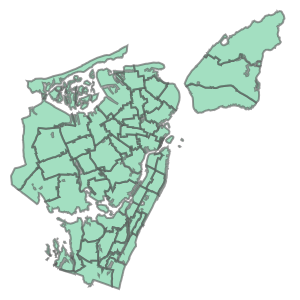

In [8]:
from shapely.geometry import shape, GeometryCollection, Point
from shapely.ops import transform
from functools import partial

newyork_geo_coll = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in newyork_data])

proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3414'))

newyork_geo_coll_new = transform(proj, newyork_geo_coll)
newyork_geo_coll_new

The following code parses through the json and pulls out the area names and finds the centroid coordinates into lists, 

In [9]:
bor_subb_id = []
sub_bor_name = []
centroidx = []
centroidy = []
geometry = []

i = 0
while(i != len(newyork_data)):
    bor_subb_id.append(newyork_data[i]['properties']['bor_subb'])
    sub_bor_name.append(newyork_data[i]['properties']['name'])
    mypoly = shape(newyork_data[i]['geometry'])
    centroidx.append(mypoly.centroid.x)
    centroidy.append(mypoly.centroid.y)
    geometry.append(newyork_data[i]['geometry'])
    i = i + 1

Let's create a dataframe of all the sub-borough areas and their names and also their centroid locations.

In [10]:
NYC_df = pd.DataFrame(columns=['Sub-borough_id', 'Sub_borough_name','Latitude', 'Longitude', 'Coordinates'])

NYC_df['Sub-borough_id'] = bor_subb_id
NYC_df['Sub_borough_name'] = sub_bor_name
NYC_df['Longitude'] = centroidx
NYC_df['Latitude'] = centroidy
NYC_df['Coordinates'] = geometry

NYC_df.head()

Sub-borough_id             Sub_borough_name   Latitude  Longitude  \
0             501                  North Shore  40.627058 -74.119209   
1             309                  East Harlem  40.794674 -73.935177   
2             502                   Mid-Island  40.593419 -74.137534   
3             503                  South Shore  40.541474 -74.186647   
4             310  Washington Heights / Inwood  40.853896 -73.932686   

                                         Coordinates  
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...  
1  {'type': 'MultiPolygon', 'coordinates': [[[[-7...  
2  {'type': 'MultiPolygon', 'coordinates': [[[[-7...  
3  {'type': 'MultiPolygon', 'coordinates': [[[[-7...  
4  {'type': 'MultiPolygon', 'coordinates': [[[[-7...

In [11]:
# The code was removed by Watson Studio for sharing.

{'file_name': 'NYC_geodata.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstoneproject-donotdelete-pr-djsnullrdmehby',
 'asset_id': '16717f6a-400c-49cd-bbff-dde2a9542f85'}

In [12]:
NYC_df.shape

(55, 5)

I want to display along the sub-boroughs the corresponding Borough. For that, let's merge the first data frame where we got the list of sub-boroughs with the NYC_df.

In [13]:
# Merge boroughs name into the main dataframe
df_newyorkcity = NYC_df.join(df_ny_geodata.set_index('ID'), on='Sub-borough_id')

df_newyorkcity.head()

Sub-borough_id             Sub_borough_name   Latitude  Longitude  \
0             501                  North Shore  40.627058 -74.119209   
1             309                  East Harlem  40.794674 -73.935177   
2             502                   Mid-Island  40.593419 -74.137534   
3             503                  South Shore  40.541474 -74.186647   
4             310  Washington Heights / Inwood  40.853896 -73.932686   

                                         Coordinates  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   
1  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   
2  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   
3  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   
4  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   

              Sub-borough name        Borough  
0                  North Shore  Staten Island  
1                  East Harlem      Manhattan  
2                   Mid-Island  Staten Island  
3                  South Shore  Staten Island  
4  Washington Heights / Inwood      Manhattan

In [14]:
df_Neighborhood_NYC= df_newyorkcity[['Sub-borough_id', 'Sub-borough name','Latitude', 'Longitude', 'Borough']]
df_Neighborhood_NYC.head()

Sub-borough_id             Sub-borough name   Latitude  Longitude  \
0             501                  North Shore  40.627058 -74.119209   
1             309                  East Harlem  40.794674 -73.935177   
2             502                   Mid-Island  40.593419 -74.137534   
3             503                  South Shore  40.541474 -74.186647   
4             310  Washington Heights / Inwood  40.853896 -73.932686   

         Borough  
0  Staten Island  
1      Manhattan  
2  Staten Island  
3  Staten Island  
4      Manhattan

###### Create a map of New York City with neighborhoods superimposed on top

In [15]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [44]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Neighborhood_NYC['Latitude'], df_Neighborhood_NYC['Longitude'], df_Neighborhood_NYC['Borough'], df_Neighborhood_NYC['Sub-borough name']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

##### 1-3 Hispanic Population Data

Now that we got an accurate geospatial data of the neighborhoods. The next step is to import our population data, more precisely the number of hispanic population for each neighborhood.

In [17]:
body = client_6996118af62d4a65aa44b81dd05ed2b5.get_object(Bucket='capstoneproject-donotdelete-pr-djsnullrdmehby',Key='InfoshareData hispanic population 2017.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df_Popdata = pd.read_csv(body)
df_Popdata.head()


Sub-borough Area  Not Hispanic/Latino  Hispanic/Latino  \
0       Mott Haven / Hunts Point                52316           108659   
1      Morrisania / East Tremont                64369           110555   
2      Highbridge / S. Concourse                49902            94638   
3   University Heights / Fordham                44456            95882   
4  Kingsbridge Heights / Mosholu                38342            95082   

   Percentage_hispanic/Latino   Total  
0                      0.6750  160975  
1                      0.6320  174924  
2                      0.6548  144540  
3                      0.6832  140338  
4                      0.7126  133424

In [18]:
df_Popdata=df_Popdata.drop(columns=['Not Hispanic/Latino','Total'])
df_Popdata.head()

Sub-borough Area  Hispanic/Latino  Percentage_hispanic/Latino
0       Mott Haven / Hunts Point           108659                      0.6750
1      Morrisania / East Tremont           110555                      0.6320
2      Highbridge / S. Concourse            94638                      0.6548
3   University Heights / Fordham            95882                      0.6832
4  Kingsbridge Heights / Mosholu            95082                      0.7126

Let's merge that with the Neighborhood data frame.

In [19]:
df_NYC_PopGeoData = df_Neighborhood_NYC.join(df_Popdata.set_index('Sub-borough Area'), on='Sub-borough name')
df_NYC_PopGeoData.head()

Sub-borough_id             Sub-borough name   Latitude  Longitude  \
0             501                  North Shore  40.627058 -74.119209   
1             309                  East Harlem  40.794674 -73.935177   
2             502                   Mid-Island  40.593419 -74.137534   
3             503                  South Shore  40.541474 -74.186647   
4             310  Washington Heights / Inwood  40.853896 -73.932686   

         Borough  Hispanic/Latino  Percentage_hispanic/Latino  
0  Staten Island            51448                      0.2968  
1      Manhattan            58166                      0.4632  
2  Staten Island            18770                      0.1371  
3  Staten Island            16451                      0.0993  
4      Manhattan           153600                      0.6917

##### 1-4 Social Economic Data

Let's import also our Social economic data, more precisely the *Labor force participation rate* the	*Unemployment rate*, the *Median household income* and the *Median rent* for each neighborhood.

In [99]:
body = client_6996118af62d4a65aa44b81dd05ed2b5.get_object(Bucket='capstoneproject-donotdelete-pr-djsnullrdmehby',Key='NYC_SocialEconomic_Indicators.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df_SocioEco_data = pd.read_csv(body)
df_SocioEco_data.head()


Sub-Borough name  Labor force participation rate  Unemployment rate  \
0                Astoria                        0.710674           0.046137   
1              Bay Ridge                        0.637547           0.047335   
2  Bayside / Little Neck                        0.602683           0.048616   
3     Bedford Stuyvesant                        0.639627           0.047344   
4            Bensonhurst                        0.615441           0.060951   

   Median household income  Median rent, all   
0              67647.98474        1669.238634  
1              69988.79130        1477.653247  
2              71492.94040        1843.499810  
3              52896.92904        1239.190585  
4              54513.17598        1394.089409

##### 1-5 Foursquare venues scraping

The Foursquare API function I am going to use is explore, this requires some additional parameters to be passed with the url. 

- I want to be passed venues regardless of opening hours, so at 'any' time of day.
- I want it to give me a venue even if it is not open at the time of the call.

Then Foursquare has a limit of the number of venues it will pass in one call so I want to max this out at 500.

In [1]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: 20YWF503EPXMQ2H3QOUTRN11EB1EOHTZETU0U2PGVFH5SECE
CLIENT_SECRET:LJYDOVIXO3L1EXB5KUK0Z52TEO4EXUHUPNDUSBOLCFUMAEUJ


I like to comment that I checked on **Foursquare City Guide** and launch a research using the word **'Zumba'** and the results displayed those categories. Then I searched on the [Foursquare categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/) list of category venues that I think would be relevant to my project, I have come up with the following list. 

- Dance Studio
- Gym
- Gym / Fitness Center
- Athletics & Sports
- Yoga Studio

First I will get all of the venues near by our sub-boroughs and put it into a dataframe. And later, I will filter out and keep only the venues of our interest according to the category.

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&time={}&day={}&openNow={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            'any',
            'any',
            0)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Sub-borough_name', 
                  'Sub-borough Latitude', 
                  'Sub-borough Longitude', 
                  'Venue', 
                  'Venue id',          
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Category id']
    
    return(nearby_venues)

In [26]:
ALL_NYC_Venues = getNearbyVenues(names=df_NYC_PopGeoData['Sub-borough name'],
                                   latitudes=df_NYC_PopGeoData['Latitude'],
                                   longitudes=df_NYC_PopGeoData['Longitude']
                            )

North Shore
East Harlem
Mid-Island
South Shore
Washington Heights / Inwood
Astoria
Jackson Heights
Sunnyside / Woodside
Lower East Side / Chinatown
Elmhurst / Corona
Middle Village / Ridgewood
Forest Hills / Rego Park
Flushing / Whitestone
Chelsea / Clinton / Midtown
Hillcrest / Fresh Meadows
Kew Gardens / Woodhaven
Howard Beach / S. Ozone Park
Stuyvesant Town / Turtle Bay
Bayside / Little Neck
Upper East Side
Jamaica
Morningside Heights / Hamilton Heights
Bellerose / Rosedale
Rockaways
Greenwich Village / Financial District
Upper West Side
Central Harlem
Mott Haven / Hunts Point
Morrisania / East Tremont
Highbridge / S. Concourse
University Heights / Fordham
Kingsbridge Heights / Mosholu
Riverdale / Kingsbridge
Soundview / Parkchester
Throgs Neck / Co-op City
Pelham Parkway
Williamsbridge / Baychester
Bay Ridge
Williamsburg / Greenpoint
Bushwick
Bedford Stuyvesant
Brooklyn Heights / Fort Greene
Park Slope / Carroll Gardens
North Crown Heights / Prospect Heights
Brownsville / Ocean Hil

In [27]:
print(ALL_NYC_Venues.shape)
ALL_NYC_Venues.head(100)

(5360, 9)


Sub-borough_name  Sub-borough Latitude  Sub-borough Longitude  \
0       North Shore             40.627058             -74.119209   
1       North Shore             40.627058             -74.119209   
2       North Shore             40.627058             -74.119209   
3       North Shore             40.627058             -74.119209   
4       North Shore             40.627058             -74.119209   
5       North Shore             40.627058             -74.119209   
6       North Shore             40.627058             -74.119209   
7       North Shore             40.627058             -74.119209   
8       North Shore             40.627058             -74.119209   
9       North Shore             40.627058             -74.119209   
10      North Shore             40.627058             -74.119209   
11      North Shore             40.627058             -74.119209   
12      North Shore             40.627058             -74.119209   
13      North Shore             40.627058             -74.119209   
14      North Shore             40.627058             -74.119209   
15      North Shore             40.627058             -74.119209   
16      North Shore             40.627058             -74.119209   
17      North Shore             40.627058             -74.119209   
18      North Shore             40.627058             -74.119209   
19      North Shore             40.627058             -74.119209   
20      North Shore             40.627058             -74.119209   
21      North Shore             40.627058             -74.119209   
22      North Shore             40.627058             -74.119209   
23      North Shore             40.627058             -74.119209   
24      North Shore             40.627058             -74.119209   
25      North Shore             40.627058             -74.119209   
26      North Shore             40.627058             -74.119209   
27      North Shore             40.627058             -74.119209   
28      North Shore             40.627058             -74.119209   
29      North Shore             40.627058             -74.119209   
30      North Shore             40.627058             -74.119209   
31      North Shore             40.627058             -74.119209   
32      North Shore             40.627058             -74.119209   
33      North Shore             40.627058             -74.119209   
34      North Shore             40.627058             -74.119209   
35      North Shore             40.627058             -74.119209   
36      North Shore             40.627058             -74.119209   
37      North Shore             40.627058             -74.119209   
38      North Shore             40.627058             -74.119209   
39      North Shore             40.627058             -74.119209   
40      North Shore             40.627058             -74.119209   
41      North Shore             40.627058             -74.119209   
42      North Shore             40.627058             -74.119209   
43      North Shore             40.627058             -74.119209   
44      North Shore             40.627058             -74.119209   
45      North Shore             40.627058             -74.119209   
46      North Shore             40.627058             -74.119209   
47      North Shore             40.627058             -74.119209   
48      North Shore             40.627058             -74.119209   
49      North Shore             40.627058             -74.119209   
50      North Shore             40.627058             -74.119209   
51      North Shore             40.627058             -74.119209   
52      North Shore             40.627058             -74.119209   
53      North Shore             40.627058             -74.119209   
54      North Shore             40.627058             -74.119209   
55      North Shore             40.627058             -74.119209   
56      North Shore             40.627058             -74.119209   
57      North Shore             40.627058             -74.1

In [28]:
Fitness_Centers= ALL_NYC_Venues[ALL_NYC_Venues['Venue Category']== 'Gym / Fitness Center']

print(Fitness_Centers.shape)
Fitness_Centers.head()

(63, 9)


Sub-borough_name  Sub-borough Latitude  Sub-borough Longitude  \
16                   North Shore             40.627058             -74.119209   
81                   North Shore             40.627058             -74.119209   
131                  East Harlem             40.794674             -73.935177   
202                   Mid-Island             40.593419             -74.137534   
354  Washington Heights / Inwood             40.853896             -73.932686   

                                  Venue                  Venue id  \
16   Staten Island YMCA Broadway Branch  4bb7b1353db7b713ee65209a   
81                           LA Fitness  58ef45dbee628b4eddf3e781   
131                      Planet Fitness  54bfbce8498e98016396c2cf   
202             Jewish Community Center  4b9960cbf964a520eb7635e3   
354                      Planet Fitness  53bbf3be498e18ec3a07c2b0   

     Venue Latitude  Venue Longitude        Venue Category  \
16        40.625047       -74.113832  Gym / Fitness Center   
81        40.625049       -74.139276  Gym / Fitness Center   
131       40.795220       -73.931172  Gym / Fitness Center   
202       40.594959       -74.126310  Gym / Fitness Center   
354       40.847536       -73.937937  Gym / Fitness Center   

                  Category id  
16   4bf58dd8d48988d175941735  
81   4bf58dd8d48988d175941735  
131  4bf58dd8d48988d175941735  
202  4bf58dd8d48988d175941735  
354  4bf58dd8d48988d175941735

In [29]:
gyms= ALL_NYC_Venues[ALL_NYC_Venues['Venue Category']== 'Gym']

print(gyms.shape)
gyms.head()

(78, 9)


Sub-borough_name  Sub-borough Latitude  Sub-borough Longitude  \
28       North Shore             40.627058             -74.119209   
166      East Harlem             40.794674             -73.935177   
187      East Harlem             40.794674             -73.935177   
247      South Shore             40.541474             -74.186647   
404          Astoria             40.770551             -73.913783   

                  Venue                  Venue id  Venue Latitude  \
28       cko kickboxing  4fecfc3be4b0a805b05ac220       40.626308   
166       Blink Fitness  542c32d3498ea03417f1d9fd       40.801458   
187      Club Normandie  4b9d849ff964a52087b136e3       40.784921   
247                YMCA  4b40ab2cf964a520b9b925e3       40.542453   
404  Simply Fit Astoria  4d7ce85486cfa14365a2d2a0       40.769114   

     Venue Longitude Venue Category               Category id  
28        -74.131694            Gym  4bf58dd8d48988d176941735  
166       -73.947617            Gym  4bf58dd8d48988d176941735  
187       -73.948533            Gym  4bf58dd8d48988d176941735  
247       -74.163043            Gym  4bf58dd8d48988d176941735  
404       -73.912403            Gym  4bf58dd8d48988d176941735

In [30]:
Dance_Studios= ALL_NYC_Venues[ALL_NYC_Venues['Venue Category']== 'Dance Studio']

print(Dance_Studios.shape)
Dance_Studios.head()

(8, 9)


Sub-borough_name  Sub-borough Latitude  \
111                              East Harlem             40.794674   
561                          Jackson Heights             40.761596   
909               Middle Village / Ridgewood             40.710126   
1864                         Upper East Side             40.771534   
2295  Greenwich Village / Financial District             40.720479   

      Sub-borough Longitude                      Venue  \
111              -73.935177  Lorenz Latin Dance Studio   
561              -73.875683  Lorenz Latin Dance Studio   
909              -73.889445  Lorenz Latin Dance Studio   
1864             -73.955666        Ballet Academy East   
2295             -74.007067         Dance With Me SoHo   

                      Venue id  Venue Latitude  Venue Longitude  \
111   510c9cd5e4b03bf82c1dfef1       40.793660       -73.940244   
561   4d31f5e32c76a1438f706bc7       40.757627       -73.863643   
909   4c50d3c20ef3a593947cf57a       40.701256       -73.888724   
1864  4b15b11df964a520a0b223e3       40.782803       -73.950723   
2295  4bc11de1abf49521cf98c093       40.722578       -74.001363   

     Venue Category               Category id  
111    Dance Studio  4bf58dd8d48988d134941735  
561    Dance Studio  4bf58dd8d48988d134941735  
909    Dance Studio  4bf58dd8d48988d134941735  
1864   Dance Studio  4bf58dd8d48988d134941735  
2295   Dance Studio  4bf58dd8d48988d134941735

In [31]:
Yoga_Studios= ALL_NYC_Venues[ALL_NYC_Venues['Venue Category']== 'Yoga Studio']

print(Yoga_Studios.shape)
Yoga_Studios.head()

(40, 9)


Sub-borough_name  Sub-borough Latitude  \
161                   East Harlem             40.794674   
428                       Astoria             40.770551   
677          Sunnyside / Woodside             40.740321   
703   Lower East Side / Chinatown             40.719690   
1019     Forest Hills / Rego Park             40.721806   

      Sub-borough Longitude                        Venue  \
161              -73.935177           Harlem Yoga Studio   
428              -73.913783  The Giving Tree Yoga Studio   
677              -73.919088                The Yoga Room   
703              -73.986176          Stanton Street Yoga   
1019             -73.851635                 Zen and Yoga   

                      Venue id  Venue Latitude  Venue Longitude  \
161   4d48fce9a0ef548126b5edf6       40.807077       -73.944010   
428   4a80aa8df964a520dcf51fe3       40.775025       -73.912182   
677   4a935020f964a5208a1f20e3       40.755630       -73.922450   
703   4f458580e4b0288c74fd21fc       40.719908       -73.983115   
1019  4c64b110ee03ef3b735dbaac       40.720789       -73.844501   

     Venue Category               Category id  
161     Yoga Studio  4bf58dd8d48988d102941735  
428     Yoga Studio  4bf58dd8d48988d102941735  
677     Yoga Studio  4bf58dd8d48988d102941735  
703     Yoga Studio  4bf58dd8d48988d102941735  
1019    Yoga Studio  4bf58dd8d48988d102941735

In [32]:
Athletics_Sports= ALL_NYC_Venues[ALL_NYC_Venues['Venue Category']== 'Athletics & Sports']

print(Athletics_Sports.shape)
Athletics_Sports.head()

(10, 9)


Sub-borough_name  Sub-borough Latitude  \
219                               Mid-Island             40.593419   
1162                   Flushing / Whitestone             40.770985   
1899                                 Jamaica             40.690962   
2106                    Bellerose / Rosedale             40.680622   
2319  Greenwich Village / Financial District             40.720479   

      Sub-borough Longitude                                     Venue  \
219              -74.137534  College of Staten Island Handball Courts   
1162             -73.814611           Queens Archery Lanes & Pro Shop   
1899             -73.778189          Roy Wilkins Southern Queens Park   
2106             -73.753697          Roy Wilkins Southern Queens Park   
2319             -74.007067           Asphalt Green Battery Park City   

                      Venue id  Venue Latitude  Venue Longitude  \
219   4c9a44a178ffa093bf096b75       40.603498       -74.150505   
1162  4b5ca1a0f964a520fc3a29e3       40.761575       -73.795557   
1899  51c4f3ae498ed6347862323b       40.688066       -73.773908   
2106  51c4f3ae498ed6347862323b       40.688066       -73.773908   
2319  51bcd723498eecb51dd996bc       40.715924       -74.014673   

          Venue Category               Category id  
219   Athletics & Sports  4f4528bc4b90abdf24c9de85  
1162  Athletics & Sports  4f4528bc4b90abdf24c9de85  
1899  Athletics & Sports  4f4528bc4b90abdf24c9de85  
2106  Athletics & Sports  4f4528bc4b90abdf24c9de85  
2319  Athletics & Sports  4f4528bc4b90abdf24c9de85

In [33]:
VenuesOfInterest_df = pd.concat([Fitness_Centers, gyms, Dance_Studios, Yoga_Studios, Athletics_Sports ], ignore_index=True)
print(VenuesOfInterest_df.shape)
VenuesOfInterest_df.head(50)

(199, 9)


Sub-borough_name  Sub-borough Latitude  \
0                              North Shore             40.627058   
1                              North Shore             40.627058   
2                              East Harlem             40.794674   
3                               Mid-Island             40.593419   
4              Washington Heights / Inwood             40.853896   
5                          Jackson Heights             40.761596   
6                     Sunnyside / Woodside             40.740321   
7                        Elmhurst / Corona             40.742283   
8                        Elmhurst / Corona             40.742283   
9                        Elmhurst / Corona             40.742283   
10              Middle Village / Ridgewood             40.710126   
11              Middle Village / Ridgewood             40.710126   
12                Forest Hills / Rego Park             40.721806   
13                Forest Hills / Rego Park             40.721806   
14                   Flushing / Whitestone             40.770985   
15             Chelsea / Clinton / Midtown             40.753912   
16             Chelsea / Clinton / Midtown             40.753912   
17             Chelsea / Clinton / Midtown             40.753912   
18             Chelsea / Clinton / Midtown             40.753912   
19                 Kew Gardens / Woodhaven             40.695732   
20            Howard Beach / S. Ozone Park             40.668592   
21            Howard Beach / S. Ozone Park             40.668592   
22            Stuyvesant Town / Turtle Bay             40.745670   
23            Stuyvesant Town / Turtle Bay             40.745670   
24            Stuyvesant Town / Turtle Bay             40.745670   
25            Stuyvesant Town / Turtle Bay             40.745670   
26                   Bayside / Little Neck             40.756202   
27                         Upper East Side             40.771534   
28                                 Jamaica             40.690962   
29                    Bellerose / Rosedale             40.680622   
30                               Rockaways             40.592931   
31  Greenwich Village / Financial District             40.720479   
32                          Central Harlem             40.813444   
33                Mott Haven / Hunts Point             40.812098   
34                Mott Haven / Hunts Point             40.812098   
35               Morrisania / East Tremont             40.845484   
36               Morrisania / East Tremont             40.845484   
37               Highbridge / S. Concourse             40.832571   
38            University Heights / Fordham             40.849074   
39            University Heights / Fordham             40.849074   
40           Kingsbridge Heights / Mosholu             40.870455   
41                 Soundview / Parkchester             40.825627   
42                Throgs Neck / Co-op City             40.849918   
43                          Pelham Parkway             40.856051   
44                          Pelham Parkway             40.856051   
45                          Pelham Parkway             40.856051   
46                               Bay Ridge             40.622529   
47                               Bay Ridge             40.622529   
48                               Bay Ridge             40.622529   
49                      Bedford Stuyvesant             40.689562   

    Sub-borough Longitude                                        Venue  \
0              -74.119209           Staten Island YMCA Broadway Branch   
1              -74.119209                                   LA Fitness   
2              -73.935177                               Planet Fitness   
3              -74.137534                      Jewish Community Center   
4              -73.932686                               Planet Fitness   
5              -73.875683     Louis Armstrong Recreation Center/ELMCOR   
6              -73.919088              

Let's check the unique values of locations (latitudes and longitudes) to check duplicates or overlapping between two or more su-boroughs.

In [34]:
VenuesOfInterest_df[['Venue Latitude','Venue Longitude', 'Sub-borough_name']].nunique()

Venue Latitude      174
Venue Longitude     173
Sub-borough_name     54
dtype: int64

So this is saying there are 29 venues that I have got that are duplicates. 
We can find and drop those.

Take note also that 54 out of the 55 sub-boroughs of NYC have venues related to the 5 categories of our interets. 

In [35]:
VenuesOfInterest_df.sort_values(by=['Venue'], inplace=True)
VenuesOfInterest_df.drop_duplicates(subset=['Venue Latitude','Venue Latitude'], keep='first', inplace=True)
VenuesOfInterest_df.reset_index(inplace=True, drop=True)
VenuesOfInterest_df.shape

(174, 9)

Now we are down to 174 venues, I am going to plot them on a map of New York City so we can see the spread around the city.

Before I do this I know the Folium library doesnt like apostrophes (') or quotes (") in the data so I am going to blanket remove them from the dataframe

In [36]:
VenuesOfInterest_df['Venue'] = VenuesOfInterest_df['Venue'].str.replace("'", "")
VenuesOfInterest_df['Venue'] = VenuesOfInterest_df['Venue'].str.replace('"', "")
VenuesOfInterest_df.head(10)

Sub-borough_name  Sub-borough Latitude  \
0            Stuyvesant Town / Turtle Bay             40.745670   
1           Kingsbridge Heights / Mosholu             40.870455   
2  Greenwich Village / Financial District             40.720479   
3                 Riverdale / Kingsbridge             40.889389   
4                               Bay Ridge             40.622529   
5                           East Flatbush             40.647440   
6                         Upper East Side             40.771534   
7                         Upper East Side             40.771534   
8                      Bedford Stuyvesant             40.689562   
9            Park Slope / Carroll Gardens             40.671635   

   Sub-borough Longitude                             Venue  \
0             -73.975228               305 Fitness MIDTOWN   
1             -73.890514             APEX - Lehman College   
2             -74.007067   Asphalt Green Battery Park City   
3             -73.905433  Astral Fitness & Wellness Center   
4             -74.024005                   Bad Ass Academy   
5             -73.934202                           Bad Gym   
6             -73.955666               Ballet Academy East   
7             -73.955666                   Barrys Bootcamp   
8             -73.940676           Bedford-Stuyvesant YMCA   
9             -73.988224                 Bend & Bloom Yoga   

                   Venue id  Venue Latitude  Venue Longitude  \
0  5672e6a5498ea77d7c6aafe4       40.746790       -73.982885   
1  4c5ee8ae7f661b8d94464f1c       40.874849       -73.893296   
2  51bcd723498eecb51dd996bc       40.715924       -74.014673   
3  4cf6ae55d3a8a1cd71a9d243       40.876705       -73.906372   
4  507b1071c84c958374e004b3       40.636020       -74.027570   
5  4cde3e8acf9060fc8521d58d       40.650007       -73.950000   
6  4b15b11df964a520a0b223e3       40.782803       -73.950723   
7  521c185b11d26fe322a0b139       40.763501       -73.962023   
8  49d7bda4f964a520565d1fe3       40.685166       -73.953858   
9  4b43ebdef964a52014ee25e3       40.677445       -73.981170   

         Venue Category               Category id  
0  Gym / Fitness Center  4bf58dd8d48988d175941735  
1                   Gym  4bf58dd8d48988d176941735  
2    Athletics & Sports  4f4528bc4b90abdf24c9de85  
3                   Gym  4bf58dd8d48988d176941735  
4  Gym / Fitness Center  4bf58dd8d48988d175941735  
5  Gym / Fitness Center  4bf58dd8d48988d175941735  
6          Dance Studio  4bf58dd8d48988d134941735  
7  Gym / Fitness Center  4bf58dd8d48988d175941735  
8  Gym / Fitness Center  4bf58dd8d48988d175941735  
9           Yoga Studio  4bf58dd8d48988d102941735

In [37]:
from folium import plugins # for adding the marker cluster

# create map of nyc using latitude and longitude values
nyc_lat=40.7127281
nyc_lon=-74.0060152

map_nyc = folium.Map(location=[nyc_lat, nyc_lon], zoom_start=12)

# instantiate a mark cluster object for the incidents in the dataframe
venues = plugins.MarkerCluster().add_to(map_nyc)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, venue, category in zip(
    VenuesOfInterest_df['Venue Latitude'], 
    VenuesOfInterest_df['Venue Longitude'], 
    VenuesOfInterest_df['Venue'], 
    VenuesOfInterest_df['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(html=label, parse_html=True)
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(venues)

# display map
map_nyc        

For last, let's check if any of those sports center that we selected  corresponds to a Zumba Center. We will do this by checking if the name of the venue is composed of the word "Zumba". We will get also the Tips of each venue and see if in it there is any mention of Zumba classes.

In [41]:
ZumbaCenters= VenuesOfInterest_df[VenuesOfInterest_df['Venue']== '%zumba%']
print(ZumbaCenters.shape)
ZumbaCenters.head()

(0, 9)


Empty DataFrame
Columns: [Sub-borough_name, Sub-borough Latitude, Sub-borough Longitude, Venue, Venue id, Venue Latitude, Venue Longitude, Venue Category, Category id]
Index: []

In [2]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: LKLU34RJNPZYIFSZIPMPDGLXDCOOKXZYZ5Z5CZYQUZO4OX3Y
CLIENT_SECRET:WLOVCASDG55ROM0BORICUKGCDZODKM30CCJY02WP2OYNSTFQ


In [42]:
for neigh, name, venue_id in zip(VenuesOfInterest_df['Sub-borough_name'],VenuesOfInterest_df['Venue'], VenuesOfInterest_df['Venue id']):
    limit=15
    url1 = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)       

In [43]:
results1 = requests.get(url1).json()
results1

{'meta': {'code': 200, 'requestId': '5ea21a8e1d67cb656ab4663c'},
 'response': {'tips': {'count': 0, 'items': []}}}

In [169]:
Tips_list=[]
Tips_list.append([(
            VenuesOfInterest_df['Sub-borough_name'],
            VenuesOfInterest_df['Venue'], 
            VenuesOfInterest_df['Venue id'], 
            results1['response']['tips']['items'][0]['text']) for l in results1])
            
Tips = pd.DataFrame([item for Tip_list in Tips_list for item in Tip_list])
Tips.columns = ['Sub-borough_name', 
                  'Venue', 
                  'Venue id',          
                  'Tips']
Tips.head()

Sub-borough_name  \
0  0                   Chelsea/Clinton/Midtown
1 ...   
1  0                   Chelsea/Clinton/Midtown
1 ...   

                                               Venue  \
0  0                              305 Fitness MID...   
1  0                              305 Fitness MID...   

                                            Venue id  \
0  0      5672e6a5498ea77d7c6aafe4
1      4c5ee8a...   
1  0      5672e6a5498ea77d7c6aafe4
1      4c5ee8a...   

                                                Tips  
0  Today was my 4th class and honestly I am so gl...  
1  Today was my 4th class and honestly I am so gl...

In [170]:
Tips.shape

(2, 4)

In [171]:
Zumba_Centers= Tips[Tips['Tips']== '%zumba%']
print(Zumba_Centers.shape)
Zumba_Centers.head()

(0, 4)


Empty DataFrame
Columns: [Sub-borough_name, Venue, Venue id, Tips]
Index: []

It seems that none of the venues that we got from Foursquare corresponds to a Zumba Center or at least offers Zumba class. But this can be wrong as we only get access to the actual tip not all.

So now we have all the Sports centers (Gyms, Fitness Centers, Dance and Yoga Studios) in vicinity of every sub-borough of New York City, and we know also  the number of hispanic population for each sub-borough.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new Zumba Center!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of New York City that have low Sports center density, particularly those with low number of Gym, Fitness Center, Dance and Yoga Studio . 

In first step we have identified the venues of our interests with the required data: location and category (according to Foursquare categorization).

Second step in our analysis will calculate and explore **'Sports center density'** across different areas of New York City: we will take into consideration locations with **no more than two sports centers in radius of 1000 meters**. Note that we already saw that **there is no Zumba Center in radius of 2500 meters** (radius used for making the API call in Foursquare). We will use **Choropleth** to identify a few promising areas with low number of sports centers in general in vicinity and focus our attention on those areas. 

In the third step we will focus on most promising areas and within those we want to define locations with high Hispanic population density as those are our customer target. Again, we will use **Choropleth** to reduce the number of promising areas.

In the final step we will create clusters (using **k-means clustering**) using location and socio-economic data to group all the areas. From that we will look specifically the most promising areas from the previous step to identify the optimal neighborhood to propose to our stakeholders for the opening of Zumba place.

## Analysis <a name="analysis"></a>

#### Analysis of venues

We will first perform analysis of the venues data that we got previously.

Firstly, let's calculate the distance between each venue and its corresponding centroid.Distance in meters. And after, we will take the venues that have distance less than 1000m from the center of its corresponding area. Then we will count the venues for each area and create a shortlist of sub-boroughs.

In [73]:
import geopy.distance

distance= []

for sLat, sLong, vLat, vLong in zip(VenuesOfInterest_df['Sub-borough Latitude'],
                                    VenuesOfInterest_df['Sub-borough Longitude'],
                                    VenuesOfInterest_df['Venue Latitude'],
                                    VenuesOfInterest_df['Venue Longitude']
                                   ):

        coords_1 = (sLat, sLong)
        coords_2 = (vLat, vLong)
        dis = geopy.distance.vincenty(coords_1, coords_2).m
        distance.append("{0:8.2f}".format(dis))
distance

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:13: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


['  658.56',
 '  541.41',
 '  817.91',
 ' 1410.78',
 ' 1528.17',
 ' 1366.26',
 ' 1319.18',
 ' 1041.07',
 ' 1216.49',
 '  878.60',
 ' 1909.20',
 ' 1258.47',
 ' 1500.84',
 ' 1128.77',
 ' 1162.57',
 '  567.34',
 ' 1360.74',
 ' 1106.03',
 ' 1642.77',
 ' 1520.71',
 ' 1150.99',
 '  643.19',
 ' 1356.50',
 ' 1398.21',
 ' 1039.98',
 '  820.67',
 '  380.76',
 ' 1646.64',
 '  865.57',
 ' 1257.71',
 ' 1079.11',
 ' 1077.98',
 ' 1345.75',
 '  829.88',
 ' 1432.76',
 ' 1193.39',
 ' 1124.49',
 '  605.84',
 '  906.37',
 ' 1348.39',
 ' 1885.99',
 ' 1272.56',
 '  663.35',
 '  842.09',
 '  836.11',
 ' 1563.28',
 ' 1567.86',
 ' 1477.51',
 '  938.38',
 ' 1721.05',
 '  636.91',
 '  456.70',
 ' 1016.10',
 '  103.65',
 ' 1378.12',
 '  941.28',
 ' 1169.67',
 ' 1342.72',
 '  708.65',
 ' 1279.57',
 ' 1769.06',
 ' 1736.19',
 '  535.27',
 ' 1891.71',
 ' 1055.09',
 '  764.21',
 ' 1092.79',
 ' 1152.93',
 '  779.25',
 ' 1269.52',
 ' 1204.39',
 ' 1291.24',
 ' 1044.78',
 ' 1301.34',
 '  742.26',
 ' 1080.44',
 '  749.45',

In [74]:
VenuesOfInterest_df['m_to_centroid'] = distance
VenuesOfInterest_df.sort_values('m_to_centroid')

Sub-borough_name  Sub-borough Latitude  \
53                Williamsburg / Greenpoint             40.718098   
142                                 Astoria             40.770551   
146             Lower East Side / Chinatown             40.719690   
120                Brownsville / Ocean Hill             40.667754   
125                             East Harlem             40.794674   
138                Brownsville / Ocean Hill             40.667754   
26                                 Bushwick             40.696667   
105             Chelsea / Clinton / Midtown             40.753912   
141  Greenwich Village / Financial District             40.720479   
98                              East Harlem             40.794674   
165               Williamsburg / Greenpoint             40.718098   
51                                  Astoria             40.770551   
104                Forest Hills / Rego Park             40.721806   
103                               Bay Ridge             40.622529   
147                             North Shore             40.627058   
154                                 Astoria             40.770551   
134              Middle Village / Ridgewood             40.710126   
62   Greenwich Village / Financial District             40.720479   
1             Kingsbridge Heights / Mosholu             40.870455   
119                    Sunnyside / Woodside             40.740321   
15                Highbridge / S. Concourse             40.832571   
160                          Central Harlem             40.813444   
161  North Crown Heights / Prospect Heights             40.674650   
124                          Central Harlem             40.813444   
37                          Upper East Side             40.771534   
166                Forest Hills / Rego Park             40.721806   
170            Park Slope / Carroll Gardens             40.671635   
50                    Bayside / Little Neck             40.756202   
92           Brooklyn Heights / Fort Greene             40.692500   
21                             Coney Island             40.582086   
0              Stuyvesant Town / Turtle Bay             40.745670   
118  Greenwich Village / Financial District             40.720479   
149  Greenwich Village / Financial District             40.720479   
109                            Borough Park             40.629710   
42                                Bay Ridge             40.622529   
169               Williamsburg / Greenpoint             40.718098   
86                           Central Harlem             40.813444   
58                  Kew Gardens / Woodhaven             40.695732   
77                          Upper West Side             40.785645   
110                      Bedford Stuyvesant             40.689562   
129                         Upper West Side             40.785645   
74   Greenwich Village / Financial District             40.720479   
85                                Bay Ridge             40.622529   
76                          Upper West Side             40.785645   
65                           Pelham Parkway             40.856051   
106                            Coney Island             40.582086   
68             Stuyvesant Town / Turtle Bay             40.745670   
80                    Bayside / Little Neck             40.756202   
2    Greenwich Village / Financial District             40.720479   
25               Sheepshead Bay / Gravesend             40.594638   
33                Highbridge / S. Concourse             40.832571   
127             Washington Heights / Inwood             40.853896   
44                 Forest Hills / Rego Park             40.721806   
43               Sheepshead Bay / Gravesend             40.594638   
81                    Bayside / Little Neck             40.756202   
28                                 Bushwick             40.696667   
153  Greenwich Village / Financial District             40.720479   
9              Park Slope

In [75]:
VenuesOfInterest_df['m_to_centroid']=VenuesOfInterest_df['m_to_centroid'].astype(float)
print('Average distance to closest sports center from each area center:', VenuesOfInterest_df['m_to_centroid'].mean())

Average distance to closest sports center from each area center: 1097.2751724137934


OK, so on average sports center can be found within ~1000m from every area center candidate. This leaves us plenty of choices.

We will add to our shortlist the sub-boroughs that have maximum 2 sports centers located within a radius of 1000m from the center of the area.

So let's select the ones that has a distance less than 1000 meters. Then we will group by sub-borough and count the number of venues for each sub-borough.

In [76]:
#sports centers located at more than 1000m from its centroid
Venues_Outside1000m = VenuesOfInterest_df[VenuesOfInterest_df['m_to_centroid'] >1000]
Venues_Outside1000m= Venues_Outside1000m.drop(columns=['Venue id', 'Category id'])

#sports centers located within 1000m from its centroid
Venues_Within1000m = VenuesOfInterest_df[VenuesOfInterest_df['m_to_centroid']< 1000]
Venues_Within1000m= Venues_Within1000m.drop(columns=['Venue id', 'Category id'])

print(Venues_Outside1000m.shape)
print(Venues_Within1000m.shape)


(109, 8)
(65, 8)


Now we have the venues and their areas within a distance less than 1000m, we can group the dataframe by the areas and see a total count of number of venues in each area.

In [77]:
Venues_Within1000m_count= Venues_Within1000m.groupby(['Sub-borough_name']).count()
Venues_Within1000m_count=Venues_Within1000m_count[['Sub-borough Latitude']].rename(columns={'Sub-borough Latitude': 'Venue Count'}).reset_index()
Venues_Within1000m_count.head()

Sub-borough_name  Venue Count
0                Astoria            3
1              Bay Ridge            3
2  Bayside / Little Neck            3
3     Bedford Stuyvesant            1
4           Borough Park            1

In [78]:
Venues_Within1000m_count['Venue Count'].describe()

count    31.000000
mean      2.096774
std       1.325515
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       7.000000
Name: Venue Count, dtype: float64

We can see that we have 31 sub-borough areas having venues comprised within 1000m of its centroid.

Lets plot the count of venues on a Choropleth map overlayed on New York City with the sub-boroughs highlighted.

In [79]:
import folium

nyc_geo = r'newyork-geojson.json' # geojson file

# create a plain singapore map
M = folium.Map(location=[40.7127281, -74.0060152], zoom_start=10, tiles='mapboxbright')


# add a Choropleth map with venue counts determining colour 
folium.Choropleth(
    geo_data=nyc_geo,
    data=Venues_Within1000m_count,
    columns=['Sub-borough_name','Venue Count'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Count of Venues'    
).add_to(M)

# add an overlay of highlighting and the Area Name when hovering over the polygon
folium.GeoJson(data=nyc_geo,
               name='name',
               style_function=lambda x: {'color':'black','fillColor':'transparent','weight':2},
               tooltip=folium.GeoJsonTooltip(fields=['name'],
                                            labels=False,
                                            sticky=False),
               highlight_function=lambda x: {'weight':3,'fillColor':'grey'}
).add_to(M)

M

Any area highlighted in black has no venues located inside it or has but located outside a radius of 1000m from its center. We are going to want to focus on the areas in Yellow.

I will create a shortlist of these areas.

In [80]:
Venues_Within1000m_count = Venues_Within1000m_count.sort_values('Venue Count', ascending=True).reset_index(drop=True)
Venues_Within1000m_count

Sub-borough_name  Venue Count
0                  Kew Gardens / Woodhaven            1
1                               Mid-Island            1
2              Lower East Side / Chinatown            1
3            Kingsbridge Heights / Mosholu            1
4              Washington Heights / Inwood            1
5                           Pelham Parkway            1
6   North Crown Heights / Prospect Heights            1
7                              North Shore            1
8           Brooklyn Heights / Fort Greene            1
9                             Borough Park            1
10                      Bedford Stuyvesant            1
11                    Sunnyside / Woodside            1
12                         Upper East Side            1
13             Chelsea / Clinton / Midtown            2
14                Brownsville / Ocean Hill            2
15                             East Harlem            2
16              Sheepshead Bay / Gravesend            2
17               Highbridge / S. Concourse            2
18              Middle Village / Ridgewood            2
19                                Bushwick            2
20                            Coney Island            2
21            Stuyvesant Town / Turtle Bay            3
22                                 Astoria            3
23                Forest Hills / Rego Park            3
24                          Central Harlem            3
25                   Bayside / Little Neck            3
26                               Bay Ridge            3
27            Park Slope / Carroll Gardens            3
28                         Upper West Side            4
29               Williamsburg / Greenpoint            4
30  Greenwich Village / Financial District            7

In [81]:
area_shortlist1 = Venues_Within1000m_count[Venues_Within1000m_count['Venue Count']<=2]
area_shortlist1= area_shortlist1[['Sub-borough_name']]
print(area_shortlist1.count())
area_shortlist1

Sub-borough_name    21
dtype: int64


Sub-borough_name
0                  Kew Gardens / Woodhaven
1                               Mid-Island
2              Lower East Side / Chinatown
3            Kingsbridge Heights / Mosholu
4              Washington Heights / Inwood
5                           Pelham Parkway
6   North Crown Heights / Prospect Heights
7                              North Shore
8           Brooklyn Heights / Fort Greene
9                             Borough Park
10                      Bedford Stuyvesant
11                    Sunnyside / Woodside
12                         Upper East Side
13             Chelsea / Clinton / Midtown
14                Brownsville / Ocean Hill
15                             East Harlem
16              Sheepshead Bay / Gravesend
17               Highbridge / S. Concourse
18              Middle Village / Ridgewood
19                                Bushwick
20                            Coney Island

To refine that are_shortlist, let's take it a bit further by increasing the scale: radius of 2500m. let's count the number of venues in each sub-borough using the radius defined in the Foursquare API call to identify the area that has less than two sports centers. Then let's plot it again on Choropleth map.

In [82]:
AllVenues_count= VenuesOfInterest_df.groupby(['Sub-borough_name']).count()
AllVenues_count=AllVenues_count[['Sub-borough Latitude']].rename(columns={'Sub-borough Latitude': 'Venue Count'}).reset_index()
AllVenues_count.head()

Sub-borough_name  Venue Count
0                Astoria            3
1              Bay Ridge            4
2  Bayside / Little Neck            6
3     Bedford Stuyvesant            3
4   Bellerose / Rosedale            3

In [83]:
AllVenues_count['Venue Count'].describe()

count    52.000000
mean      3.346154
std       1.769952
min       1.000000
25%       2.000000
50%       3.000000
75%       5.000000
max       8.000000
Name: Venue Count, dtype: float64

In [84]:
nyc_geo = r'newyork-geojson.json' # geojson file

# create a plain singapore map
m = folium.Map(location=[40.7127281, -74.0060152], zoom_start=10.5, tiles='mapboxbright')


# add a Choropleth map with venue counts determining colour 
folium.Choropleth(
    geo_data=nyc_geo,
    data=AllVenues_count,
    columns=['Sub-borough_name','Venue Count'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Count of all Venues'    
).add_to(m)

# add an overlay of highlighting and the Area Name when hovering over the polygon
folium.GeoJson(data=nyc_geo,
               name='name',
               style_function=lambda x: {'color':'black','fillColor':'transparent','weight':2},
               tooltip=folium.GeoJsonTooltip(fields=['name'],
                                            labels=False,
                                            sticky=False),
               highlight_function=lambda x: {'weight':3,'fillColor':'grey'}
).add_to(m)

m

Any area highlighted in black has no sports venues located inside it. We are going to want to focus on the Yellow areas.

I will create a shortlist of these areas.

In [85]:
AllVenues_count = AllVenues_count.sort_values('Venue Count', ascending=True).reset_index(drop=True)

In [86]:
Allarea_shortlist = AllVenues_count[AllVenues_count['Venue Count']<=2]
Allarea_shortlist= Allarea_shortlist[['Sub-borough_name']]
print(Allarea_shortlist.count())
Allarea_shortlist

Sub-borough_name    18
dtype: int64


Sub-borough_name
0              Washington Heights / Inwood
1                              Sunset Park
2                              South Shore
3                             Borough Park
4                                Rockaways
5              Lower East Side / Chinatown
6                          Jackson Heights
7   Morningside Heights / Hamilton Heights
8                  Kew Gardens / Woodhaven
9              Williamsbridge / Baychester
10                   Flushing / Whitestone
11                    Flatlands / Canarsie
12            East New York / Starret City
13               Hillcrest / Fresh Meadows
14                 Riverdale / Kingsbridge
15                     South Crown Heights
16                Throgs Neck / Co-op City
17                              Mid-Island

At this point we reduced to 18 our sub-borough canditates. The number of our promising areas is still high. 

#### Analysis of population data

At this point we reduced to 18 our sub-borough canditates. The number of our promising areas is still high. 

The next step is to use these reduced area candidates to see where we have the highest number of hispanic population( which are the client target of our stakeholder).

In [88]:
sub_bor_shortlist = Allarea_shortlist['Sub-borough_name'].values.tolist()
sub_bor_shortlist

['Washington Heights / Inwood',
 'Sunset Park',
 'South Shore',
 'Borough Park',
 'Rockaways',
 'Lower East Side / Chinatown',
 'Jackson Heights',
 'Morningside Heights / Hamilton Heights',
 'Kew Gardens / Woodhaven',
 'Williamsbridge / Baychester',
 'Flushing / Whitestone',
 'Flatlands / Canarsie',
 'East New York / Starret City',
 'Hillcrest / Fresh Meadows',
 'Riverdale / Kingsbridge',
 'South Crown Heights',
 'Throgs Neck / Co-op City',
 'Mid-Island']

In [89]:
NYC_PopShort= df_NYC_PopGeoData[df_NYC_PopGeoData['Sub-borough name'].isin(sub_bor_shortlist)]
NYC_PopShort= NYC_PopShort.drop(['Sub-borough_id'], axis=1)
NYC_PopShort.reset_index(inplace=True, drop=True)
NYC_PopShort

Sub-borough name   Latitude  Longitude  \
0                               Mid-Island  40.593419 -74.137534   
1                              South Shore  40.541474 -74.186647   
2              Washington Heights / Inwood  40.853896 -73.932686   
3                          Jackson Heights  40.761596 -73.875683   
4              Lower East Side / Chinatown  40.719690 -73.986176   
5                    Flushing / Whitestone  40.770985 -73.814611   
6                Hillcrest / Fresh Meadows  40.725392 -73.795069   
7                  Kew Gardens / Woodhaven  40.695732 -73.841285   
8   Morningside Heights / Hamilton Heights  40.816448 -73.954510   
9                                Rockaways  40.592931 -73.821198   
10                 Riverdale / Kingsbridge  40.889389 -73.905433   
11                Throgs Neck / Co-op City  40.849918 -73.816014   
12             Williamsbridge / Baychester  40.889869 -73.861439   
13            East New York / Starret City  40.665082 -73.877984   
14                    Flatlands / Canarsie  40.615550 -73.899515   
15                     South Crown Heights  40.661056 -73.947478   
16                             Sunset Park  40.649737 -74.001947   
17                            Borough Park  40.629710 -73.982542   

          Borough  Hispanic/Latino  Percentage_hispanic/Latino  
0   Staten Island            18770                      0.1371  
1   Staten Island            16451                      0.0993  
2       Manhattan           153600                      0.6917  
3          Queens           120497                      0.6691  
4       Manhattan            39963                      0.2501  
5          Queens            43847                      0.1738  
6          Queens            31645                      0.1916  
7          Queens            65493                      0.4224  
8       Manhattan            50085                      0.3807  
9          Queens            30041                      0.2440  
10          Bronx            53352                      0.4797  
11          Bronx            47063                      0.3840  
12          Bronx            33739                      0.2287  
13       Brooklyn            58978                      0.3712  
14       Brooklyn            17452                      0.0824  
15       Brooklyn             9738                      0.0883  
16       Brooklyn            61632                      0.4109  
17       Brooklyn            17781                      0.1082

In [90]:
nyc_geo = r'newyork-geojson.json' # geojson file

# create a plain singapore map
p = folium.Map(location=[40.7127281, -74.0060152], zoom_start=10, tiles='mapboxbright')


# add a Choropleth map with venue counts determining colour 
folium.Choropleth(
    geo_data=nyc_geo,
    data=NYC_PopShort,
    columns=['Sub-borough name','Percentage_hispanic/Latino'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Percentage_hispanic/Latino Population'    
).add_to(p)

# add an overlay of highlighting and the Area Name when hovering over the polygon
folium.GeoJson(data=nyc_geo,
               name='name',
               style_function=lambda x: {'color':'black','fillColor':'transparent','weight':2},
               tooltip=folium.GeoJsonTooltip(fields=['name'],
                                            labels=False,
                                            sticky=False),
               highlight_function=lambda x: {'weight':3,'fillColor':'grey'}
).add_to(p)

p

We get to see from that map that there are two sub-boroughs that have high percentage in Hispanic/Latino population (close to 70%) which are: **Washington Heights / Inwood** , **Jackson Heights**. A third option can be considered with ~48% of Hispanic/Latino population: **Riverdale / Kingsbridge**. We will narrow down our area candidates to these

In [91]:
NYC_PopShort=NYC_PopShort.sort_values('Percentage_hispanic/Latino', ascending=False).reset_index()
PopArea_shortlist = NYC_PopShort['Sub-borough name'][:3]
PopArea_shortlist 

0    Washington Heights / Inwood
1                Jackson Heights
2        Riverdale / Kingsbridge
Name: Sub-borough name, dtype: object

#### Clustering Social-Economic Data

I wanted to utilise some machine learning techniques in my project and I thought that clustering along socio-economic characteristics distributions would be an interesting option. The data contains 4 main informations: Labor force participation rate, Unemployment rate, Median household income, and Median rent, for each sub-borough area.

In [100]:
df_SocioEco_data.dtypes

Sub-Borough name                   object
Labor force participation rate    float64
Unemployment rate                 float64
Median household income           float64
Median rent, all                  float64
dtype: object

Let's start with setting the index of the dataframe to be the name of the area.

In [101]:
df_SocioEco_data = df_SocioEco_data.set_index('Sub-Borough name')
df_SocioEco_data.head()

Labor force participation rate  Unemployment rate  \
Sub-Borough name                                                           
Astoria                                      0.710674           0.046137   
Bay Ridge                                    0.637547           0.047335   
Bayside / Little Neck                        0.602683           0.048616   
Bedford Stuyvesant                           0.639627           0.047344   
Bensonhurst                                  0.615441           0.060951   

                       Median household income  Median rent, all   
Sub-Borough name                                                   
Astoria                            67647.98474        1669.238634  
Bay Ridge                          69988.79130        1477.653247  
Bayside / Little Neck              71492.94040        1843.499810  
Bedford Stuyvesant                 52896.92904        1239.190585  
Bensonhurst                        54513.17598        1394.089409

Now we need to preprocess the data by transforming it into normalized values.

In [102]:
from sklearn.preprocessing import StandardScaler

X = df_SocioEco_data.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-6.20528407e-01,  1.06983971e-01,  5.20000406e-01],
       [-5.85830398e-01,  1.90935249e-01,  6.84863928e-03],
       [-5.48742718e-01,  2.44880433e-01,  9.86750150e-01],
       [-5.85584189e-01, -4.22051620e-01, -6.31861537e-01],
       [-1.91430558e-01, -3.64086131e-01, -2.16972873e-01],
       [-4.45129520e-01, -6.61186671e-01, -7.23077502e-02],
       [-3.49681752e-01,  1.06381656e+00,  1.18327636e+00],
       [ 4.05211950e+00, -1.57891266e+00, -1.53806572e+00],
       [-4.42965783e-01, -4.67773452e-01, -2.86352576e-02],
       [ 4.27740200e-01, -5.26140971e-01, -1.09042269e+00],
       [-5.59436854e-01,  1.40806432e+00,  1.80833888e+00],
       [-1.83777821e-01, -9.99111580e-01, -1.16957908e+00],
       [-2.60896095e-01, -5.15541985e-01, -4.43523918e-01],
       [ 6.17627730e-01, -9.75282136e-01, -1.50804088e+00],
       [ 6.44148723e-01, -9.74697365e-01, -6.07295760e-01],
       [-7.23075668e-01, -4.18945020e-01,  3.41439458e-02],
       [-1.67252890e-01, -2.50567337e-01

Finally lets cluster the areas into 4 groups.

In [126]:
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[2 2 2 0 0 0 2 3 2 0 1 0 0 0 0 2 0 2 2 1 3 2 2 0 0 0 2 2 0 3 3 0 2 2 1 0 2
 2 0 0 2 0 0 2 2 1 2 0 0 3 1 1 0 0 2]


Let's assign the grouping labels to a column in the datraframe

In [127]:
df_SocioEco_data["Clus_km"] = labels
df_SocioEco_data.head(5)

Labor force participation rate  Unemployment rate  \
Sub-Borough name                                                           
Astoria                                      0.710674           0.046137   
Bay Ridge                                    0.637547           0.047335   
Bayside / Little Neck                        0.602683           0.048616   
Bedford Stuyvesant                           0.639627           0.047344   
Bensonhurst                                  0.615441           0.060951   

                       Median household income  Median rent, all   Clus_km  
Sub-Borough name                                                            
Astoria                            67647.98474        1669.238634        2  
Bay Ridge                          69988.79130        1477.653247        2  
Bayside / Little Neck              71492.94040        1843.499810        2  
Bedford Stuyvesant                 52896.92904        1239.190585        0  
Bensonhurst                        54513.17598        1394.089409        0

In [128]:
df_SocioEco_data.groupby('Clus_km').mean()

Labor force participation rate  Unemployment rate  \
Clus_km                                                      
0                              0.618321           0.074625   
1                              0.727545           0.037209   
2                              0.644337           0.047801   
3                              0.576035           0.154471   

         Median household income  Median rent, all   
Clus_km                                              
0                   50544.425321        1266.927045  
1                  127262.970867        2310.913803  
2                   71417.577654        1564.953681  
3                   26140.806926        1052.292926

Seeing at this results, we can define as follow each group:

CLUSTER 1: Medium to High unemployement rate, Medium to Low income, medium to Low rent price \
CLUSTER 2: Low unemployement rate, High income, High rent price\
CLUSTER 3: Medium to Low unemployement rate, Medium to High income, medium rent price\
CLUSTER 4: Low unemployement rate, High income, High rent price

Lets see what cluster the three areas selected previously have been assigned to.

In [129]:
print(df_SocioEco_data.loc['Washington Heights / Inwood','Clus_km'])
print(df_SocioEco_data.loc['Jackson Heights','Clus_km'])
print(df_SocioEco_data.loc['Riverdale / Kingsbridge','Clus_km'])

0
2
0


We can see that the 3 areas that we shortlisted before **Washington Heights / Inwood** and **Riverdale / Kingsbridge** are from the same group where unemployement is medium to high, median household income is Low , and where rent price is low. 
**Jackson Heights** where unemployement rate is medium to Low , median household income is medium to high income, and where rent price is acceptable.

I need to add the labels to the neighborhood dataframe

In [130]:
df_Neighborhood_NYC['Clus_km'] = df_Neighborhood_NYC['Sub-borough name'].map(df_SocioEco_data['Clus_km'].to_dict())

df_Neighborhood_NYC.head()


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Sub-borough_id             Sub-borough name   Latitude  Longitude  \
0             501                  North Shore  40.627058 -74.119209   
1             309                  East Harlem  40.794674 -73.935177   
2             502                   Mid-Island  40.593419 -74.137534   
3             503                  South Shore  40.541474 -74.186647   
4             310  Washington Heights / Inwood  40.853896 -73.932686   

         Borough  Clus_km  
0  Staten Island        2  
1      Manhattan        0  
2  Staten Island        2  
3  Staten Island        2  
4      Manhattan        0

Now lets increase the label number for each by 1 because otherwise the map markers wont be able to display the 0.

In [131]:
df_Neighborhood_NYC['Clus_km'] = df_Neighborhood_NYC['Clus_km'] + 1
df_Neighborhood_NYC.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Sub-borough_id             Sub-borough name   Latitude  Longitude  \
0             501                  North Shore  40.627058 -74.119209   
1             309                  East Harlem  40.794674 -73.935177   
2             502                   Mid-Island  40.593419 -74.137534   
3             503                  South Shore  40.541474 -74.186647   
4             310  Washington Heights / Inwood  40.853896 -73.932686   

         Borough  Clus_km  
0  Staten Island        3  
1      Manhattan        1  
2  Staten Island        3  
3  Staten Island        3  
4      Manhattan        1

Lets see the clusters across New York on a map

In [132]:
# create map
map_clusters = folium.Map(location=[40.7127281, -74.0060152], zoom_start=10)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.viridis(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neigh, cluster in zip(df_Neighborhood_NYC['Latitude'], 
                                    df_Neighborhood_NYC['Longitude'], 
                                    df_Neighborhood_NYC['Sub-borough name'], 
                                    df_Neighborhood_NYC['Clus_km']):
    if cluster >= 1:
        label = folium.Popup(str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=6,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

map_clusters

For conclusion we can say that **Jackson Heights** is the best area to open a Zumba Center: there are really few sports venues in its vicinity, the percentage of Hispanic/Latino population is really high as the stakeholders requisted. Besides, there the unemployement rate is quite Low , median household income is medium to high so people will be able to afford the type of service our stakeholders will offer. And finally that  sub-borough is located in a zone where rent price is acceptable even low.